<a href="https://colab.research.google.com/github/vivek86-ai/Resnet50_classification/blob/master/CIFAR10_ResNet_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras

In [0]:
from keras.applications.resnet50 import ResNet50, preprocess_input

from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import AveragePooling2D 
from keras.layers import Dropout

from keras.optimizers import Adam

from keras.models import Model

from keras.datasets import cifar10

import numpy as np
import cv2

from sklearn.metrics import classification_report
from imutils import paths

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [65]:
#Mounting GDrive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [66]:
!ls 'gdrive/My Drive/ResNet_CIFAR10'

ResNet_class_data.zip


In [67]:
#Unzipping the "ResNet_class_data.zip"
!unzip -q "gdrive/My Drive/ResNet_CIFAR10/ResNet_class_data.zip"

replace data/test/backpack/00000010.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [68]:
!ls data/

test  train


In [0]:
#Dataset Path
train_path = "data/train"
test_path = "data/test"

In [0]:
#Number of classes
from glob import glob
category = glob("data/train/*")
classes = len(category)

In [0]:
#define the path to the serialized output model after training
MODEL_PATH = "fashion_resnet.model"

In [0]:
#Initializing the training, testing Augmentation
train_datagen = ImageDataGenerator(
            rotation_range=25,
            zoom_range=0.1,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            horizontal_flip=True,
            fill_mode="nearest"
            ) 


test_datagen = ImageDataGenerator()


In [0]:

#Normalizing Data
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
train_datagen.mean = mean
test_datagen.mean = mean


######We can do normalising at ImageDataGenerator by adding rescaling parameter



In [75]:
#Initializing the Training, Testing and Validation Generator

train_set = train_datagen.flow_from_directory(
                                              train_path,
                                              target_size = (224,224),
                                              class_mode = 'categorical',
                                              batch_size = 32,
                                              color_mode = 'rgb',
                                              shuffle = True
                                              )

test_set = test_datagen.flow_from_directory(
                                              test_path,
                                              target_size = (224,224),
                                              class_mode = 'categorical',
                                              batch_size = 32,
                                              color_mode = 'rgb',
                                              shuffle = False
                                            )

Validation_set = test_datagen.flow_from_directory(
                                              test_path,
                                              target_size = (224,224),
                                              class_mode = 'categorical',
                                              batch_size = 32,
                                              color_mode = 'rgb',
                                              shuffle = False
                                              )




Found 475 images belonging to 4 classes.
Found 264 images belonging to 4 classes.
Found 264 images belonging to 4 classes.


In [76]:
##Load ResNet50
base_model = ResNet50(weights = 'imagenet', include_top = False, input_tensor=Input(shape=(224, 224, 3)))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
#Construct the FNN for ResNet50
model = base_model.output
model = AveragePooling2D(pool_size=(7,7))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(256, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(classes, activation='softmax')(model)

finalModel = Model(inputs = base_model.input, outputs = model )


In [0]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process

for layer in base_model.layers:
  layer.trainable = False

In [0]:
#Compiling Model

INIT_LR = 1e-4
NUM_EPOCHS = 20

opt = Adam(lr=INIT_LR, decay = INIT_LR/NUM_EPOCHS)

finalModel.compile(optimizer=opt, loss = 'binary_crossentropy', metrics = ['accuracy'])


In [81]:
##Train the model
BS = 32
finalModel.fit_generator(
                         train_set, 
                         steps_per_epoch=len(list(paths.list_files(train_path))) // BS,
                         epochs = NUM_EPOCHS,
                         validation_data = Validation_set,
                         validation_steps = len(list(paths.list_files(test_path))) // BS
                         )

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


14/14 [==============================] - 19s 1s/step - loss: 0.6498 - accuracy: 0.7015 - val_loss: 0.3193 - val_accuracy: 0.8184
Epoch 2/20
14/14 [==============================] - 16s 1s/step - loss: 0.3893 - accuracy: 0.8253 - val_loss: 0.2285 - val_accuracy: 0.9030
Epoch 3/20
14/14 [==============================] - 15s 1s/step - loss: 0.2417 - accuracy: 0.9007 - val_loss: 0.0357 - val_accuracy: 0.9364
Epoch 4/20
14/14 [==============================] - 14s 988ms/step - loss: 0.1697 - accuracy: 0.9503 - val_loss: 0.0508 - val_accuracy: 0.9612
Epoch 5/20
14/14 [==============================] - 14s 981ms/step - loss: 0.1445 - accuracy: 0.9509 - val_loss: 0.1701 - val_accuracy: 0.9634
Epoch 6/20
14/14 [==============================] - 17s 1s/step - loss: 0.1103 - accuracy: 0.9661 - val_loss: 0.0831 - val_accuracy: 0.9752
Epoch 7/20
14/14 [==============================] - 14s 981ms/step - loss: 0.0955 - accuracy: 0.9704 - val_loss: 0.1136 - val_accuracy: 0.9752
Epoch 8/20
14/14 [====

In [0]:
##Reset the testing generator and then use our trained model to make prediction of the data
test_set.reset()

In [83]:
predIndex = finalModel.predict_generator(test_set, steps = (len(list(paths.list_files(test_path))) // BS) + 1)
predIndex

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


array([[9.9995792e-01, 1.8551329e-05, 1.0233485e-05, 1.3280652e-05],
       [9.9889177e-01, 1.2173413e-05, 2.3163410e-04, 8.6447975e-04],
       [9.9497038e-01, 1.7983170e-03, 5.3580437e-04, 2.6955055e-03],
       ...,
       [1.6961514e-03, 5.9259112e-04, 1.0298775e-04, 9.9760830e-01],
       [1.6375045e-05, 3.0287070e-05, 3.3158783e-05, 9.9992025e-01],
       [8.1717650e-07, 6.7873536e-08, 3.4928044e-06, 9.9999571e-01]],
      dtype=float32)

In [84]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIndex = np.argmax(predIndex, axis=1)
predIndex

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [85]:
#Display nicely formatted classification report
print(classification_report(test_set.classes, predIndex, target_names=test_set.class_indices.keys()))

print("[INFO] saving model ....")
#finalModel.save(MODEL_PATH, save_format='h5')
finalModel.save(MODEL_PATH)

              precision    recall  f1-score   support

    backpack       1.00      0.98      0.99        66
    footwear       0.96      0.98      0.97        66
     glasses       1.00      0.95      0.98        66
       watch       0.96      0.98      0.97        66

    accuracy                           0.98       264
   macro avg       0.98      0.98      0.98       264
weighted avg       0.98      0.98      0.98       264

[INFO] saving model ....


In [0]:
#Load The model
model_loaded = keras.models.load_model(MODEL_PATH)

In [87]:
!pwd

/content


In [112]:
!ls /content/data/test

backpack  footwear  glasses  watch


In [122]:
!ls /content/data/test/watch

00000000.jpg  00000016.jpg  00000032.jpeg  00000049.jpg   00000069.jpg
00000001.jpg  00000018.jpg  00000033.jpg   00000050.jpg   00000070.jpg
00000002.jpg  00000019.jpg  00000034.jpg   00000051.jpg   00000071.jpg
00000003.jpg  00000020.jpg  00000035.jpg   00000053.jpg   00000072.jpg
00000004.jpg  00000022.jpg  00000037.jpg   00000054.jpg   00000073.jpg
00000005.jpg  00000023.jpg  00000038.jpg   00000055.jpeg  00000074.jpg
00000006.jpg  00000024.jpg  00000039.jpeg  00000057.jpg   00000075.jpg
00000007.jpg  00000025.jpg  00000041.jpg   00000059.jpg   00000076.jpg
00000008.jpg  00000026.jpg  00000042.jpg   00000060.jpg   00000079.jpg
00000010.jpg  00000027.jpg  00000043.jpg   00000061.jpg   00000080.jpg
00000011.jpg  00000028.jpg  00000044.jpg   00000063.jpg
00000012.jpg  00000029.jpg  00000045.jpg   00000064.jpeg
00000014.jpg  00000030.jpg  00000046.jpg   00000066.jpg
00000015.jpg  00000031.jpg  00000048.jpeg  00000067.jpg


In [0]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from skimage import io

Input Dimensions - Image :  (224, 224, 3)


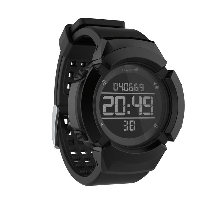

In [123]:
input_img = "/content/data/test/watch/00000025.jpg"
input_img = io.imread(input_img)
input_img = cv2.resize(input_img, dsize = (224, 224), interpolation=cv2.INTER_CUBIC)
print('Input Dimensions - Image : ',input_img.shape)
cv2_imshow(input_img)

In [124]:
#Making prediction of the above img
input_img.shape

(224, 224, 3)

In [0]:
x = image.img_to_array(input_img)
x = np.expand_dims(x, axis=0)

In [126]:
x.shape

(1, 224, 224, 3)

In [0]:
x = preprocess_input(x)

In [128]:
x.shape

(1, 224, 224, 3)

In [130]:
pred = model_loaded.predict(x)
pred

array([[1.0039501e-02, 5.2114232e-05, 6.6994151e-05, 9.8984140e-01]],
      dtype=float32)

In [131]:
cls_idx = np.argmax(pred)
if cls_idx == 0:
  print("backpack")
elif cls_idx == 1 :
  print("footwear")
elif cls_idx == 2:
  print("glasses")
else:
  print("watch")

watch


In [0]:
a = "/content/data/test/"

In [117]:
test_set.class_indices

{'backpack': 0, 'footwear': 1, 'glasses': 2, 'watch': 3}